### 모델설계

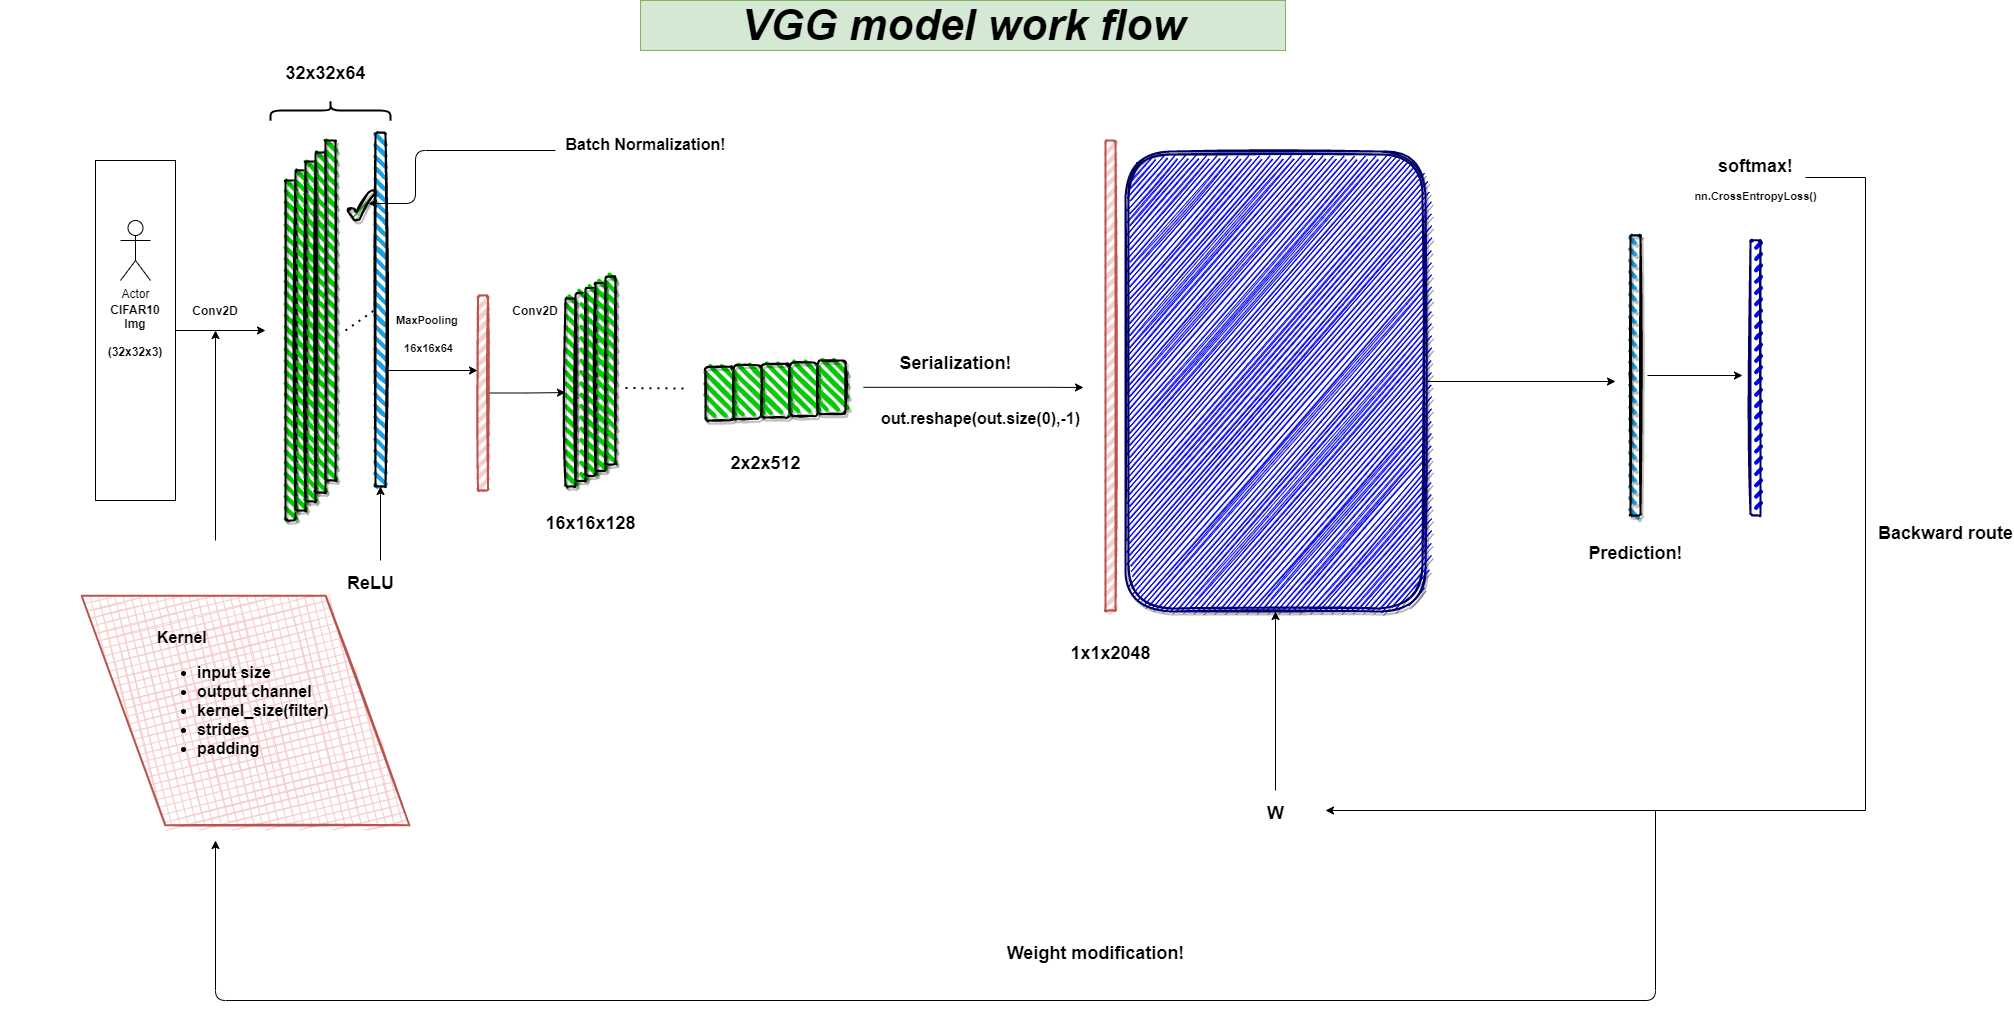

In [6]:
from IPython.display import Image

Image(data="/content/drive/MyDrive/Encore/1. Pytorch,Keras Tutorial/VGG_model (1).png")

### module configuration

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms
import pdb
import torch.nn as nn

### device -> GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### hyperparameter 지정

In [ ]:
num_epoch = 10

learning_rate = 0.01

batch_size = 100
#batch 해야하는 이유?
#로스 조정을 여러번하기 위함.
#컴퓨터 부하를 줄이기 위함(병렬처리 하니까)

num_classes = 10 
#답이 열개 



### Dataloader

In [ ]:
#step1

train_dataset = torchvision.datasets.CIFAR10(download=True,
                                                  root="../../data",
                                                  train=True, #트레이닝 데이터라는 의미
                                                  transform = transforms.ToTensor() #이미지 변환, 스케일링, 채널 변경
                                                  )

test_dataset = torchvision.datasets.CIFAR10(
                                                  root="../../data",
                                                  train=False, #테스트 데이터라는 의미
                                                  transform = transforms.ToTensor() #이미지 변환, 스케일링, 채널 변경
                                                  )

#step2 

train_dataloader = torch.utils.data.DataLoader(batch_size=batch_size,
                                               shuffle = True,
                                               dataset = train_dataset
                                               )

test_dataloader = torch.utils.data.DataLoader(batch_size=batch_size,
                                               shuffle = False,
                                               dataset = test_dataset
                                               )

Files already downloaded and verified


### Model Template


In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name,target_nums):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, target_nums) #최종채널이 몇개가 될지, 답이 몇개인지 정해준다. 


    def forward(self, x):
        out = self.features(x) #모든 레이어 다 진행 후 

        out = out.view(out.size(0), -1)  #직렬화 시킨다. 
        out = self.classifier(out) #nn.
        return out

    def _make_layers(self, cfg): 
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers) #리스트에 모아 놓은 레이어들을 unpacking 해서 seqeuntial에 넣어준다.  



# class ConvNet(nn.Module):
#     def __init__(self,num_classes): #정답의 갯수가 몇개인가를 선지정해준다. 
#         super(ConvNet,self).__init__()
        
#         #레이어 설정
#         self.layer1 = nn.Sequential(
#             #convolution 
#             nn.Conv2d(1,16,kernel_size=3,padding=1,stride=1) , 
#             #activation function
#             nn.ReLU()
#         )

#         self.layer2 = nn.MaxPool2d(kernel_size=2,stride=2) # 14 

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(16,32,kernel_size=3,padding=1,stride=1) ,
#             nn.ReLU()
#         )
#         self.layer4 = nn.MaxPool2d(kernel_size=2,stride=2) # 7

#         self.layer5 = nn.Linear(7*7*32,num_classes)
    
#     def forward(self,x):
#         #출력물
#         out = self.layer1(x) #x는 이미지 데이터.  #getter setter?
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)

#         #reshape! 
#         #pdb.set_trace()
#         out = out.reshape(out.size(0),-1) #.. 
#         out = self.layer5(out)
#         return out


### 모델 선정의

In [ ]:
model = VGG("VGG11",num_classes).to(device) #GPU 
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 학습(training)

In [ ]:
total_step = len(train_dataloader) #배치사이즈의 수 만큼 돌리는 것을 하나의 epoch으로 볼 것이다.
list_loss = []
for epoch in range(num_epoch):
    for i, (images,labels) in enumerate(train_dataloader):
        image = images.to(device) #이미지 연산을 GPU로... 병렬처리 해주겠다?
        label = labels.to(device) # image가 gpu서버에서 연산되므로... 같이가자... 

        output_forward = model(image)

        loss_w = loss_function(output_forward,label) 
        #정답과 비교 + 로스값 계산 + 양수화 시키고 증폭... log로 숫자 다시 낮추고... 확률 계산... 돌려준다. 

        optimizer.zero_grad() #초기화. 

        loss_w.backward()
        list_loss.append(loss_w.item())

        optimizer.step()

        if (i+1) % 100 == 0: 
            print("Epoch : [{}/{}], Step : [{}/{}], Loss:{:.3f}".format(epoch+1,num_epoch,i+1,total_step,loss_w.item()))



Epoch : [1/10], Step : [100/500], Loss:2.114
Epoch : [1/10], Step : [200/500], Loss:1.818
Epoch : [1/10], Step : [300/500], Loss:1.755
Epoch : [1/10], Step : [400/500], Loss:1.638
Epoch : [1/10], Step : [500/500], Loss:1.474
Epoch : [2/10], Step : [100/500], Loss:1.266
Epoch : [2/10], Step : [200/500], Loss:1.360
Epoch : [2/10], Step : [300/500], Loss:1.188
Epoch : [2/10], Step : [400/500], Loss:0.994
Epoch : [2/10], Step : [500/500], Loss:1.105
Epoch : [3/10], Step : [100/500], Loss:1.172
Epoch : [3/10], Step : [200/500], Loss:1.032
Epoch : [3/10], Step : [300/500], Loss:0.960
Epoch : [3/10], Step : [400/500], Loss:0.969
Epoch : [3/10], Step : [500/500], Loss:0.613
Epoch : [4/10], Step : [100/500], Loss:0.758
Epoch : [4/10], Step : [200/500], Loss:0.825
Epoch : [4/10], Step : [300/500], Loss:0.761
Epoch : [4/10], Step : [400/500], Loss:0.799
Epoch : [4/10], Step : [500/500], Loss:0.578
Epoch : [5/10], Step : [100/500], Loss:0.555
Epoch : [5/10], Step : [200/500], Loss:0.516
Epoch : [5

### 평가

In [ ]:
correct = 0
total = 0
correct_list = []
with torch.no_grad():
    #평가를 하는 것이므로 경사구하는 것을 하지 않는다.
    for images,labels in test_dataloader:
        
        image = images.to(device)
        labels = labels.to(device)

        outputs = model(image) #예측을 해본다. 

        _, predicted = torch.max(outputs.data,1) 

        #1의 의미. 각 '행'에서 최고인 값의 인덱스값을 주겠다는 의미가 된다.
        #_은 value, predicted은 해당 value의 index값이 된다. 
        """ 
        a = torch.randn(4, 4)
        >>>a
        tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
                [ 1.1949, -1.1127, -2.2379, -0.6702],
                [ 1.5717, -0.9207,  0.1297, -1.8768],
                [-0.6172,  1.0036, -0.6060, -0.2432]])
        >>> torch.max(a, 1)
        torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))
        
        """

        total += labels.size(0)
        
        correct += (predicted == labels).sum().item() 
        correct_list.append((predicted == labels).sum().item()/labels.size(0))
    print('Test Accuracy of the model on the 10000 test images:{}%'.format(100*correct /total))
    torch.save(model.state_dict(), 'model.ckpt') 

    

Test Accuracy of the model on the 10000 test images:80.79%


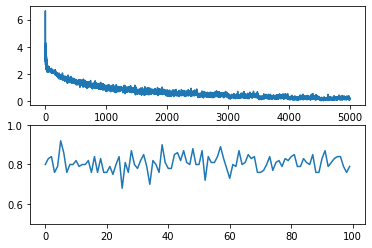

<class 'list'>
100


In [ ]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(list_loss) 

plt.subplot(2,1,2)
plt.plot(correct_list)
plt.ylim(0.5,1.0)

plt.show()
print(type(list_loss))
print(len(correct_list))


In [ ]:
from torchsummary import summary
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

#### Lesson learned! 

- Since it has no augmentation, it shows a mere 80% accuracy. 
- It seems quite reasonable to try transforms.Compose and put other augmentation techs in it.